In [22]:
%load_ext autoreload
%autoreload 2

import os
import sys

import torch
from torch.optim import SGD
from torch import nn

## Access src directory from ./notebooks/ folder
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from src.Snip import SNIP
from src.models.LeNet import LeNet300100, LeNet5
from src.optimization import epoch

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
pruning_batch_size = 128
batch_size = 64
path = '../data/'
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = MNIST(path, train=True, download=True,transform=data_transforms)
test_dataset = MNIST(path, train=False, download=True,transform=data_transforms)
pruning_data_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=pruning_batch_size, shuffle=True, num_workers=2)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, num_workers=2)


In [4]:
def train_model(model, snip = None, epochs = 20):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model = model.cuda()
    criterion = criterion.cuda()
    
    if snip:
        hooks = snip.register_masks()
        assert snip.K == snip.get_nonzero_param_number()

    train_losses = []
    test_losses = []
    accuracys = []
    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        _, loss = epoch(train_data_loader, model, criterion,snip_pruning=snip, optimizer=optimizer)
        # Phase d'evaluation
        with torch.no_grad():
            acc_test, loss_test = epoch(test_data_loader, model, criterion)

        train_losses.append(loss.avg)
        test_losses.append(loss_test.avg)
        accuracys.append(acc_test.avg)

    if snip:
        for hook in hooks:
            hook.remove()
        nonzero_params = snip.get_nonzero_param_number()
        print(nonzero_params)
        assert snip.K == nonzero_params

    return train_losses, test_losses, accuracys

def print_losses_and_acc(training_losses_, test_losses_, acc_):
    plt.title("L'erreur moyenne d'un patch dans generation des noms")
    plt.plot(np.arange(len(training_losses_)), training_losses_, label="Train")
    plt.plot(np.arange(len(test_losses_)), test_losses_, label="Test")
    plt.ylabel("L'erreur")
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()
    plt.plot(np.arange(len(acc_)), acc_)
    plt.show()

In [23]:
original_model = LeNet300100()
train_losses, test_losses, accuracys  = train_model(original_model);

=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.129s (0.129s)	Loss 2.3192 (2.3192)	Prec   0.1 (  0.1)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 0.4887 (0.8175)	Prec   0.8 (  0.8)

[TRAIN Batch 200/938]	Time 0.002s (0.003s)	Loss 0.2781 (0.5790)	Prec   0.9 (  0.8)

[TRAIN Batch 300/938]	Time 0.003s (0.003s)	Loss 0.2046 (0.4814)	Prec   0.9 (  0.9)

[TRAIN Batch 400/938]	Time 0.002s (0.003s)	Loss 0.2505 (0.4219)	Prec   0.9 (  0.9)

[TRAIN Batch 500/938]	Time 0.003s (0.003s)	Loss 0.0622 (0.3814)	Prec   1.0 (  0.9)

[TRAIN Batch 600/938]	Time 0.002s (0.003s)	Loss 0.2721 (0.3509)	Prec   0.9 (  0.9)

[TRAIN Batch 700/938]	Time 0.003s (0.003s)	Loss 0.1742 (0.3259)	Prec   0.9 (  0.9)

[TRAIN Batch 800/938]	Time 0.003s (0.003s)	Loss 0.1557 (0.3058)	Prec   1.0 (  0.9)

[TRAIN Batch 900/938]	Time 0.002s (0.003s)	Loss 0.2362 (0.2890)	Prec   0.9 (  0.9)


===============> Total time 2s	Avg loss 0.2837	Avg Prec  0.92 %

[EVAL Batch 000/157]	Time 0.072s (0.072s)	Loss 0.1353 (0.1353)	Prec   1.0 (

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.1127 (0.0690)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0671	Avg Prec  0.98 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.048s (0.048s)	Loss 0.0147 (0.0147)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.002s (0.003s)	Loss 0.0166 (0.0143)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.0092 (0.0169)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.002s (0.003s)	Loss 0.0156 (0.0147)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.003s (0.003s)	Loss 0.0112 (0.0158)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.002s (0.003s)	Loss 0.0006 (0.0166)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.003s (0.003s)	Loss 0.0021 (0.0166)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.003s (0.003s)	Loss 0.0490 (0.0181)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.002s (0.003s)	Loss 0.0166 (0.0181)	Prec   1.0 (  1.0)

[TRAIN Batch 900/938]	Time 0.002s (0.003s)	Loss 0.0451 (0.0184)	Prec   1.0 (

[EVAL Batch 000/157]	Time 0.073s (0.073s)	Loss 0.1530 (0.1530)	Prec   1.0 (  1.0)

[EVAL Batch 100/157]	Time 0.005s (0.003s)	Loss 0.2926 (0.0805)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0856	Avg Prec  0.98 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.079s (0.079s)	Loss 0.0002 (0.0002)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.004s (0.004s)	Loss 0.0002 (0.0055)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.002s (0.003s)	Loss 0.0002 (0.0073)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.004s (0.003s)	Loss 0.0000 (0.0085)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.003s (0.003s)	Loss 0.0249 (0.0095)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.003s (0.003s)	Loss 0.0023 (0.0093)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.003s (0.003s)	Loss 0.0539 (0.0093)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.003s (0.003s)	Loss 0.0009 (0.0092)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.003s (0.003s)	Loss 0.0045 (0.0091)	Prec   1.0 (

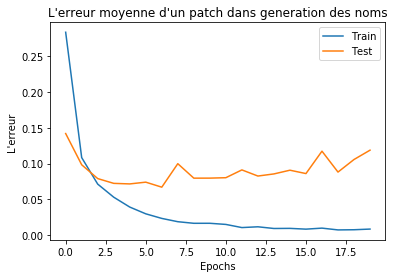

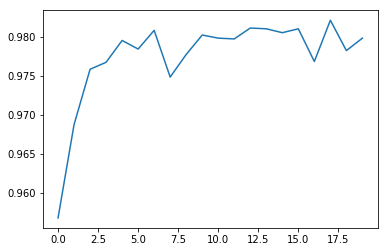

In [24]:
print_losses_and_acc(train_losses, test_losses, accuracys)

In [25]:
prune_model = LeNet300100()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = int(total_param_number * 0.2)
print("2 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 266610
4 %  of params : 53322
=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.050s (0.050s)	Loss 2.3028 (2.3028)	Prec   0.2 (  0.2)

[TRAIN Batch 100/938]	Time 0.003s (0.003s)	Loss 0.5062 (1.1530)	Prec   0.9 (  0.7)

[TRAIN Batch 200/938]	Time 0.003s (0.003s)	Loss 0.2566 (0.8020)	Prec   1.0 (  0.8)

[TRAIN Batch 300/938]	Time 0.002s (0.003s)	Loss 0.5196 (0.6587)	Prec   0.9 (  0.8)

[TRAIN Batch 400/938]	Time 0.003s (0.003s)	Loss 0.3602 (0.5730)	Prec   0.9 (  0.8)

[TRAIN Batch 500/938]	Time 0.003s (0.003s)	Loss 0.3378 (0.5185)	Prec   0.9 (  0.9)

[TRAIN Batch 600/938]	Time 0.003s (0.003s)	Loss 0.2265 (0.4805)	Prec   0.9 (  0.9)

[TRAIN Batch 700/938]	Time 0.003s (0.003s)	Loss 0.2908 (0.4521)	Prec   0.9 (  0.9)

[TRAIN Batch 800/938]	Time 0.004s (0.003s)	Loss 0.0676 (0.4264)	Prec   1.0 (  0.9)

[TRAIN Batch 900/938]	Time 0.002s (0.003s)	Loss 0.2673 (0.4043)	Prec   0.9 (  0.9)


===============> Total time 2s	Avg loss 0.3963	Avg Prec  0.89 %

[EVAL Batch 000/1

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.0779 (0.0786)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0759	Avg Prec  0.98 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.080s (0.080s)	Loss 0.0464 (0.0464)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.002s (0.004s)	Loss 0.0438 (0.0361)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.003s (0.003s)	Loss 0.0357 (0.0325)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.002s (0.003s)	Loss 0.0424 (0.0323)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.002s (0.003s)	Loss 0.0453 (0.0324)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.005s (0.003s)	Loss 0.0054 (0.0330)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.002s (0.003s)	Loss 0.0775 (0.0357)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.002s (0.003s)	Loss 0.0092 (0.0359)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.003s (0.003s)	Loss 0.0048 (0.0371)	Prec   1.0 (  1.0)

[TRAIN Batch 900/938]	Time 0.003s (0.003s)	Loss 0.0211 (0.0380)	Prec   1.0 (

[EVAL Batch 000/157]	Time 0.071s (0.071s)	Loss 0.0974 (0.0974)	Prec   1.0 (  1.0)

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.2479 (0.0818)	Prec   0.9 (  1.0)


===============> Total time 0s	Avg loss 0.0795	Avg Prec  0.98 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.071s (0.071s)	Loss 0.0013 (0.0013)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.003s (0.003s)	Loss 0.0008 (0.0108)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.002s (0.003s)	Loss 0.0029 (0.0100)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.003s (0.003s)	Loss 0.0076 (0.0094)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.003s (0.003s)	Loss 0.0017 (0.0100)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.003s (0.003s)	Loss 0.0048 (0.0096)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.003s (0.003s)	Loss 0.0382 (0.0104)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.002s (0.003s)	Loss 0.0026 (0.0109)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.002s (0.003s)	Loss 0.0011 (0.0108)	Prec   1.0 (